In [1]:
"""
Description描述: LSTM实现简单的股票预测,有前几天的股票价格来预测明天的价格
Autor作者: lhy
Date日期: 2023-1-15 22:06:12
LastEditTime: 2023-1-17 18:24:05
"""


'\nDescription描述: LSTM实现简单的股票预测,有前几天的股票价格来预测明天的价格\nAutor作者: lhy\nDate日期: 2023-1-15 22:06:12\nLastEditTime: 2023-1-17 18:24:05\n'

In [2]:
#1.导入库 对数据集进行处理
import pandas as pd 
import numpy as np
from torch.utils.data import DataLoader ,Dataset
import torch
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler


#2.定义获取数据函数，数据预处理。去除ID，股票代码，
#前一天的收盘价，交易日期等对训练集无用的数据
def getData(root,sequence_length,batch_size):
    stock_data=pd.read_csv(root)
    print(stock_data.info())
    print(stock_data.head())
    stock_data.drop('ts_code',axis=1,inplace=True) #删除股票代码
    stock_data.drop(labels="id",axis=1,inplace=True)
    stock_data.drop(labels="pre_close",axis=1,inplace=True)#删除前一天的收盘价
    stock_data.drop(labels="trade_date",axis=1,inplace=True)#删除交易日期
    print("整理后\n",stock_data.head())
    close_max=stock_data["close"].max()#收盘价的最大值
    close_min=stock_data["close"].min()#s收盘价的最小值
    #2.1对数据进行标准化min-max
    scaler=MinMaxScaler()
    df=scaler.fit_transform(stock_data)
    print("整理后1\n",stock_data.shape)
    #2.2构造X,Y
    #根据前n天的数据，预测未来一天的收盘价（close），
    #例如根据1月1日、1月2日、1月3日、1月4日、1月5日的数据
    #（每一天的数据包含8个特征），预测1月6日的收盘价。
    sequence=sequence_length
    x=[]
    y=[]
    for i in range(df.shape[0]-sequence):
        x.append(df[i:i+sequence,:])
        y.append(df[i+sequence,0])
    x=np.array(x,dtype=np.float32)
    y=np.array(y,dtype=np.float32).reshape(-1,1)
    
    print("x.shape=",x.shape)
    print("y.shape",y.shape)
    #2.3构造batch,构造训练集train与测试集test
    total_len=len(y)
    print("total_len=",total_len)
    trainx,trainy=x[:int(0.90*total_len),],y[:int(0.90*total_len),]
    testx,testy=x[int(0.90*total_len):,],y[int(0.90*total_len):,]
  
    train_loader=DataLoader(dataset=Mydataset(trainx,trainy),shuffle=True,batch_size=batch_size)
    test_loader=DataLoader(dataset=Mydataset(testx,testy),shuffle=True,batch_size=batch_size)
    return [close_max,close_min,train_loader,test_loader]
    
#3.自己重写数据集继承Dataset
class Mydataset(Dataset):
    def __init__(self,x,y):
        self.x=torch.from_numpy(x)
        self.y=torch.from_numpy(y)
    def __getitem__(self,index):
        x1=self.x[index]
        y1=self.y[index]
        return x1,y1
    def __len__(self):
        return len(self.x)
    


root="D:/2023/project_data/stockPredict-master/data/000001SH_index.csv"
close_max,close_min,train_loader,test_loader=getData(root,sequence_length=5,batch_size=64)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5430 entries, 0 to 5429
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5430 non-null   int64  
 1   ts_code     5430 non-null   object 
 2   trade_date  5430 non-null   int64  
 3   close       5430 non-null   float64
 4   open        5430 non-null   float64
 5   high        5430 non-null   float64
 6   low         5430 non-null   float64
 7   pre_close   5430 non-null   float64
 8   change      5430 non-null   float64
 9   pct_chg     5430 non-null   float64
 10  vol         5430 non-null   float64
 11  amount      5430 non-null   float64
dtypes: float64(9), int64(2), object(1)
memory usage: 509.2+ KB
None
   id    ts_code  trade_date     close      open      high       low  \
0   0  000001.SH    19980105  1220.473  1200.948  1220.495  1200.222   
1   1  000001.SH    19980106  1233.620  1223.730  1233.635  1215.409   
2   2  000001.SH    19980107  1244

In [3]:
print("close_max=,close_min=",close_max,close_min)
print("train_loader=",len(train_loader))
print("test_loader=",len(test_loader))

close_max=,close_min= 6092.057 1011.499
train_loader= 77
test_loader= 9


In [4]:
#3.构建LSTM模型
import torch.nn as nn

class lstm(nn.Module):
    def __init__(self,input_size=8,hidden_size=32,num_layer=1
                 ,output_size=1,dropout=0,batch_first=True):
        super(lstm,self).__init__()
        #lstm 的输入是batch,seq_len,input_size
        self.hidden_size=hidden_size
        self.input_size=input_size
        self.num_layer=num_layer
        self.output_size=output_size
        self.dropout=dropout
        self.batch_first=batch_first
        self.lstm=nn.LSTM(input_size=self.input_size
                         ,hidden_size=self.hidden_size
                         ,num_layers=self.num_layer
                         ,batch_first=batch_first,dropout=self.dropout)
        self.linear=nn.Linear(self.hidden_size,self.output_size)
    def forward(self,x):
        #x.shape=torch.Size([64, 5, 8])
        out,(hidden,cell)=self.lstm(x)
        #print("hidden.shape=",hidden.shape)#torch.Size([1, 64, 32])
        #print("out.shape=",out.shape)#torch.Size([64, 5, 32])
        # x.shape : batch, seq_len, hidden_size ,
        #hn.shape and cn.shape : num_layes * direction_numbers, batch, hidden_size
        a, b, c = hidden.shape
        #a= b= c= 1 64 32
        out = self.linear(hidden.reshape(a * b, c))
        return out
        



In [5]:
#4.开始对模型进行训练
input_size=8
hidden_size=32
num_layer=1
output_size=1
dropout=0
batch_first=True
epoch=400
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
totall_loss=[]#记录损失值
def train():
    model=lstm(input_size=input_size,hidden_size=hidden_size
               ,output_size=output_size,num_layer=num_layer
               ,dropout=dropout,batch_first=batch_first)
    model.to(device)
    criterion=nn.MSELoss(reduction="mean")
    optimizer=torch.optim.Adam(model.parameters(),lr=0.01)
    for i in range(epoch):
        for idx,data in enumerate(train_loader,0):
            x,y=data
            x=x.to(device)
            y=y.to(device)
            
            #y.shape=(64,1)
            pred=model(x)
            #pred.shape=(64,1)
            loss=criterion(pred,y)
            loss1=loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if i % 10==0:
            print("epoch=",i,"loss=",loss)
        totall_loss.append(loss.item())
    return model
            
            
model=train()
    
    

epoch= 0 loss= tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>)
epoch= 10 loss= tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
epoch= 20 loss= tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
epoch= 30 loss= tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
epoch= 40 loss= tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
epoch= 50 loss= tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
epoch= 60 loss= tensor(6.4572e-05, device='cuda:0', grad_fn=<MseLossBackward>)
epoch= 70 loss= tensor(4.7162e-05, device='cuda:0', grad_fn=<MseLossBackward>)
epoch= 80 loss= tensor(2.4873e-05, device='cuda:0', grad_fn=<MseLossBackward>)
epoch= 90 loss= tensor(8.7443e-05, device='cuda:0', grad_fn=<MseLossBackward>)
epoch= 100 loss= tensor(7.6496e-05, device='cuda:0', grad_fn=<MseLossBackward>)
epoch= 110 loss= tensor(9.5656e-05, device='cuda:0', grad_fn=<MseLossBackward>)
epoch= 120 loss= tensor(8.0096e-05, device='cuda:0', grad_fn=<MseLossBackwa

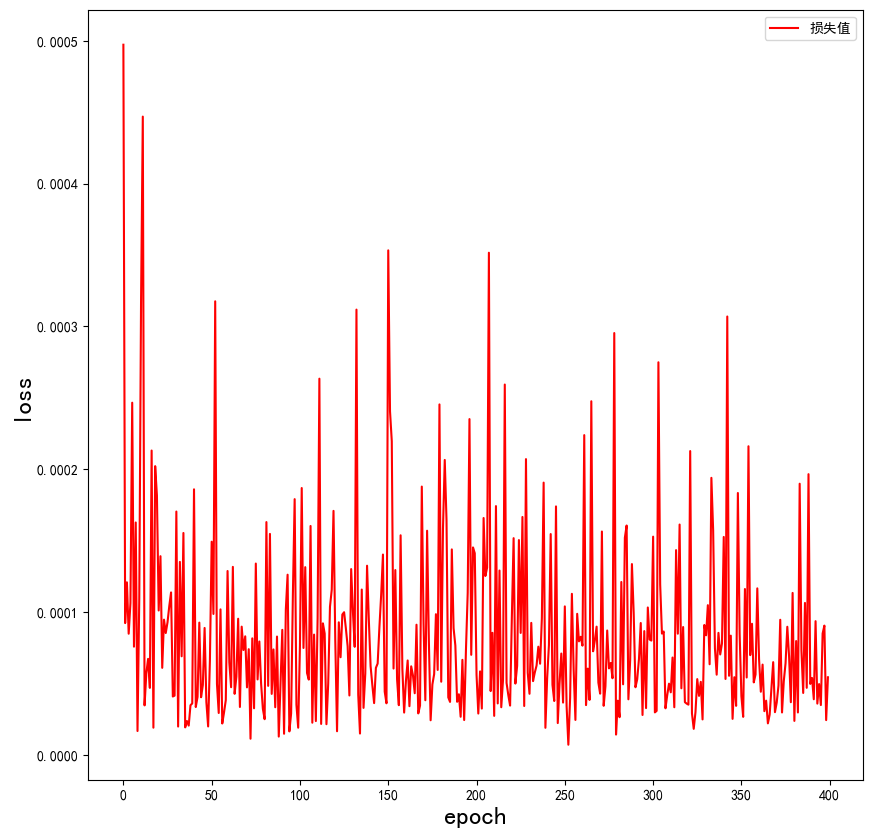

In [6]:
#6.对损失值进行画图观察变化
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'SimHei'#绘图正常显示中文
plt.rcParams['axes.unicode_minus']=False#用来正常显示负号#有中文出现的情况，
# 需要u'内容'
plt.figure(figsize=(10,10))
plt.plot(totall_loss,label="损失值",color="red")
plt.ylabel("loss",fontsize=18)
plt.xlabel("epoch",fontsize=18)
plt.legend()
plt.show()


In [7]:
#7.构建测试验证函数
def evaluate():
    preds=[]
    labels=[]
    for idx,data in enumerate(test_loader):
        x,y=data
        x=x.to(device)
        y=y.to(device)
        pred=model(x)
        print(pred.shape)
        for i in range(len(pred)):
            print("预测值是：",pred[i][0].item()*(close_max-close_min)+close_min
                  ,"真实值:",y[i][0].item()*(close_max-close_min)+close_min)
        
        
evaluate()  
    

torch.Size([64, 1])
预测值是： 2891.736101169586 真实值: 2917.8029618502856
预测值是： 2912.626776606321 真实值: 2924.8566611943243
预测值是： 2884.3026594575645 真实值: 2852.5152858563065
预测值是： 2675.2947615886924 真实值: 2703.511527326405
预测值是： 2882.2894798225166 真实值: 2938.6780418069957
预测值是： 2750.718591124237 真实值: 2768.6794360902904
预测值是： 3098.3743945492506 真实值: 3092.2906432152986
预测值是： 2858.032149061978 真实值: 2892.3782412742976
预测值是： 2742.5779019637107 真实值: 2725.249960944295
预测值是： 2779.774635947168 真实值: 2763.987467789233
预测值是： 2730.2497507103085 真实值: 2780.8990246332287
预测值是： 2725.7853552876713 真实值: 2729.243766542494
预测值是： 2741.116772039056 真实值: 2750.2961504517198
预测值是： 2857.6681535864473 真实值: 2868.458711639345
预测值是： 2668.389597835958 真实值: 2698.4658595948813
预测值是： 3205.0096248121263 真实值: 3246.57142766583
预测值是： 2720.821601679385 真实值: 2702.1295861012936
预测值是： 3107.864622675419 真实值: 3066.7967271599773
预测值是： 2811.786705590725 真实值: 2815.3686693863274
预测值是： 2767.6193976858854 真实值: 2786.887840375185
预测值是： 2806.9372683